<a href="https://colab.research.google.com/github/Nicole-Perrotta/AILabProj-LISxCanopies/blob/main/SignLanguageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enabling and testing the GPU

Install tf Nightly GPU build if necessary. `Problem: Conv2d architecture is giving issues for conv padding. Dont install tf-nightly`

In [ ]:
# !pip install tf-nightly-gpu

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/dataset.zip' 

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/Y/Y190.jpg      
  inflating: dataset/Y/Y1900.jpg     
  inflating: dataset/Y/Y1901.jpg     
  inflating: dataset/Y/Y1902.jpg     
  inflating: dataset/Y/Y1903.jpg     
  inflating: dataset/Y/Y1904.jpg     
  inflating: dataset/Y/Y1905.jpg     
  inflating: dataset/Y/Y1906.jpg     
  inflating: dataset/Y/Y1907.jpg     
  inflating: dataset/Y/Y1908.jpg     
  inflating: dataset/Y/Y1909.jpg     
  inflating: dataset/Y/Y191.jpg      
  inflating: dataset/Y/Y1910.jpg     
  inflating: dataset/Y/Y1911.jpg     
  inflating: dataset/Y/Y1912.jpg     
  inflating: dataset/Y/Y1913.jpg     
  inflating: dataset/Y/Y1914.jpg     
  inflating: dataset/Y/Y1915.jpg     
  inflating: dataset/Y/Y1916.jpg     
  inflating: dataset/Y/Y1917.jpg     
  inflating: dataset/Y/Y1918.jpg     
  inflating: dataset/Y/Y1919.jpg     
  inflating: dataset/Y/Y192.jpg      
  inflating: dataset/Y/Y1920.jpg     
  inflating: dataset/Y/Y1921.jpg     


In [ ]:
import pathlib
data_dir = '/content/dataset'
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

87000


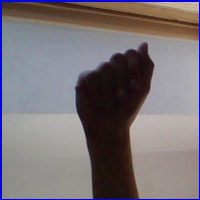

In [ ]:
import PIL
A_letter = list(data_dir.glob('A/*'))
PIL.Image.open(str(A_letter[-1]))

Creating a dataset

In [ ]:
batch_size = 16 # try with 8, 32
img_height = 32 # try with 64 , - 128 (maintain batch size at 8)
img_width = 32 # try with 64

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


Creating a test set from validation dataset

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 871
Number of test batches: 217


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


Data visualisation

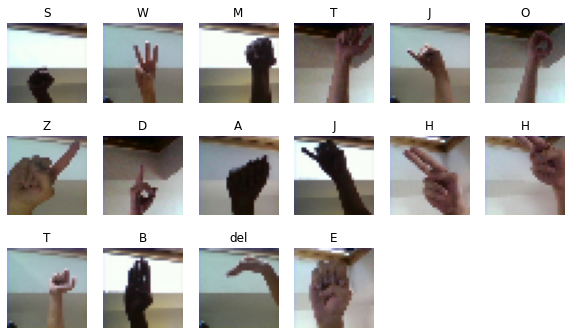

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16): #it was 30
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Checking the `image_tensor` size. batch of 32 images of shape default data 200x200x3(channels)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 32, 32, 3)
(16,)


# Configure the dataset for performance
Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

`Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
`Dataset.prefetch` overlaps data preprocessing and model execution while training.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

#Standardizing the data

In [ ]:
# normalization_layer = layers.Rescaling(1./255)

Base model

In [ ]:
''' num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
]) '''

" num_classes = len(class_names)\n\nmodel = Sequential([\n  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),\n  layers.Conv2D(16, 3, padding='same', activation='relu'),\n  layers.MaxPooling2D(),\n  layers.Conv2D(32, 3, padding='same', activation='relu'),\n  layers.MaxPooling2D(),\n  layers.Conv2D(64, 3, padding='same', activation='relu'),\n  layers.MaxPooling2D(),\n  layers.Flatten(),\n  layers.Dense(128, activation='relu'),\n  layers.Dense(num_classes)\n]) "

In [ ]:
"""ResNet50V2
base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(img_height, img_width, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling='none',
                                                        )
"""
""""MobnileNetV2
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_height, img_width, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling='none',
                                                        )
"""
""""MobnileNet
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(img_height, img_width, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling='none',
                                                        )
"""
""""EfficientNet"""
base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=(img_height, img_width, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling='none',
                                                        )
base_model.trainable = False
base_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization[0][0]']          
                    

In [ ]:
#with tf.device('/gpu:0'):
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape) #(16, 1, 1, 2048)

(16, 1, 1, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape) #(16, 2048)

(16, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape) #(16, 29)

(16, 29)


Modify pre-processing according to the network you are using

In [ ]:
"""
ResnNet50V2
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
MobileNet
preprocess_input = tf.keras.applications.mobilenet.preprocess_input
EfficientNetB0"""
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
print(outputs)
model = tf.keras.Model(inputs, outputs) #KerasTensor(type_spec=TensorSpec(shape=(None, 29), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")

KerasTensor(type_spec=TensorSpec(shape=(None, 29), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")


compile model

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 29)                37149     
                                                             

In [ ]:
len(model.trainable_variables) #2

2

Initial check before training

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

871/871 [==============================] - 20s 17ms/step - loss: 9.9531 - accuracy: 0.0376


In [ ]:
early_stop = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", # monitor validation loss (that is, the loss computed for the validation holdout)
        min_delta=1e-2, # "no longer improving" being defined as "an improvement lower than 1e-2"
        patience=10, # "no longer improving" being further defined as "for at least 10 consecutive epochs"
        verbose=1
    )
]

In [ ]:
def adapt_learning_rate(epoch):
    return 0.001 * (epoch + 1)

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)


In [ ]:
import time
start = time.time()
with tf.device('/gpu:0'):
    history = model.fit(
        train_ds, 
        validation_data=val_ds,
        epochs=20,
        callbacks=[early_stop,lr_scheduler],
    )
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/20
4350/4350 [==============================] - 99s 20ms/step - loss: 3.3967 - accuracy: 0.0352 - val_loss: 3.3673 - val_accuracy: 0.0402 - lr: 0.0010
Epoch 2/20
4350/4350 [==============================] - 62s 14ms/step - loss: 3.3672 - accuracy: 0.0354 - val_loss: 3.3673 - val_accuracy: 0.0402 - lr: 0.0020
Epoch 3/20
4350/4350 [==============================] - 61s 14ms/step - loss: 3.3672 - accuracy: 0.0338 - val_loss: 3.3673 - val_accuracy: 0.0402 - lr: 0.0030
Epoch 4/20
4350/4350 [==============================] - 62s 14ms/step - loss: 3.3672 - accuracy: 0.0350 - val_loss: 3.3673 - val_accuracy: 0.0402 - lr: 0.0040
Epoch 5/20
4350/4350 [==============================] - 62s 14ms/step - loss: 3.3674 - accuracy: 0.0330 - val_loss: 3.3673 - val_accuracy: 0.0399 - lr: 0.0050
Epoch 6/20
4350/4350 [==============================] - 61s 14ms/step - loss: 3.3672 - accuracy: 0.0344 - val_loss: 3.3673 - val_accuracy: 0.0399 - lr: 0.0060
Epoch 7/20
4350/4350 [========================

# Learning curves
The learning curves of the training and validation accuracy/loss when using the ResNetV2 base model as a fixed feature extractor.



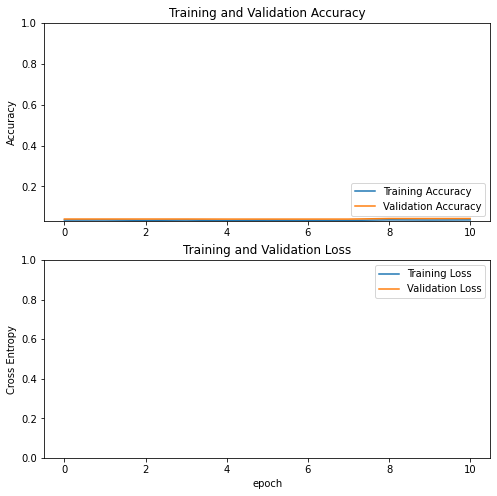

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Finetuning with layer training
Please follow from https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning and try to change the layers trainable to true and decide on how many layers you want to re-train.

In [ ]:
base_model.trainable = True

# Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  237


#Continue training the model
If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 29)                37149     
                                                             

In [ ]:
len(model.trainable_variables)

125

batch_size=32 -> ResNet50V2 -> 29 min -> 0.7 accuracy

batch_size=16 -> ResNet50V2 -> 14 min -> 0.77 accuracy

batch_size=16 -> MobileNetV2 -> 13 min -> 0.65 accuracy

batch_size=16 -> MobileNet -> 6 min -> 0.09 accuracy

batch_size=16 -> EfficientNetB0 -> 31 min -> 0.94 accuracy

#Continue training the model
If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


start = time.time()
with tf.device('/gpu:0'):
  history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 11/20
4350/4350 [==============================] - 177s 38ms/step - loss: 1.3522 - accuracy: 0.5915 - val_loss: 0.6086 - val_accuracy: 0.7990
Epoch 12/20
4350/4350 [==============================] - 161s 37ms/step - loss: 0.5091 - accuracy: 0.8355 - val_loss: 0.3816 - val_accuracy: 0.8730
Epoch 13/20
4350/4350 [==============================] - 161s 37ms/step - loss: 0.3506 - accuracy: 0.8874 - val_loss: 0.4541 - val_accuracy: 0.8729
Epoch 14/20
4350/4350 [==============================] - 164s 38ms/step - loss: 0.2926 - accuracy: 0.9086 - val_loss: 0.4864 - val_accuracy: 0.8660
Epoch 15/20
4350/4350 [==============================] - 164s 38ms/step - loss: 0.2544 - accuracy: 0.9219 - val_loss: 0.3287 - val_accuracy: 0.9052
Epoch 16/20
4350/4350 [==============================] - 161s 37ms/step - loss: 0.2388 - accuracy: 0.9269 - val_loss: 0.2092 - val_accuracy: 0.9305
Epoch 17/20
4350/4350 [==============================] - 162s 37ms/step - loss: 0.2306 - accuracy: 0.9329 - val_

Finetuning curves and accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

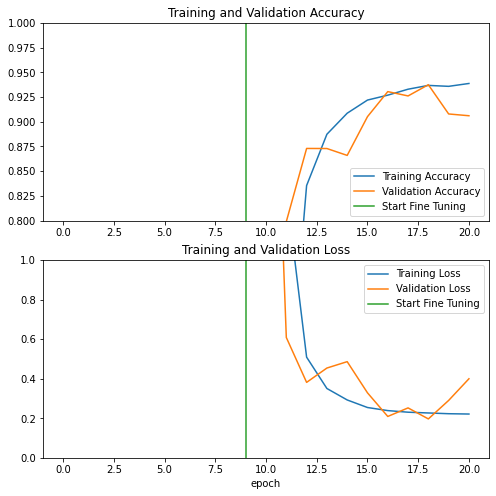

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and prediction
Finally you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

217/217 [==============================] - 4s 17ms/step - loss: 0.4403 - accuracy: 0.9078
Test accuracy : 0.9078341126441956


Saving the model

In [ ]:
model.save("model_16EfficientNetB0_2")

In [ ]:
!zip -r model_16EfficientNetB0_2.zip /content/model_16EfficientNetB0_2 
from google.colab import files
files.download("/content/model_16EfficientNetB0_2.zip")

Loading the model

In [ ]:
!unzip '/content/model_8EfficientNetB0.zip' 

Archive:  /content/model_8EfficientNetB0.zip
   creating: model_8EfficientNetB0/assets/
  inflating: model_8EfficientNetB0/keras_metadata.pb  
  inflating: model_8EfficientNetB0/saved_model.pb  
   creating: model_8EfficientNetB0/variables/
  inflating: model_8EfficientNetB0/variables/variables.data-00000-of-00001  
  inflating: model_8EfficientNetB0/variables/variables.index  


In [ ]:
loaded_model = tf.keras.models.load_model("model_8EfficientNetB0")
#loss, accuracy = loaded_model.evaluate(test_ds)
#print('Test accuracy :', accuracy)

And now you are all set to use this model to predict the hand sign language



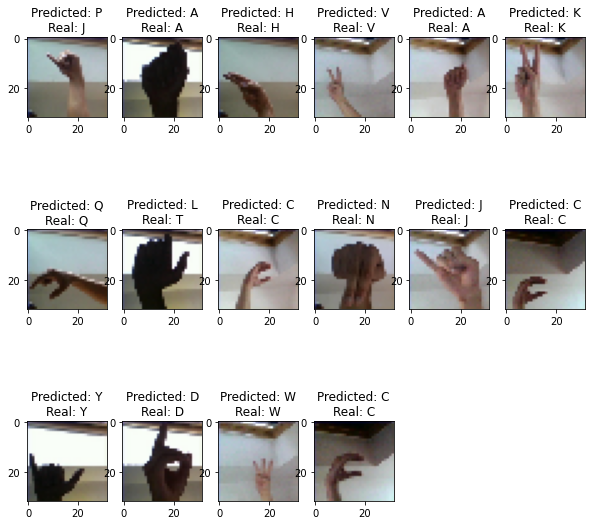

In [ ]:
"""
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

print(predictions)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("Predicted class: " + class_names[predictions[i]] + "\n" + "Real class: " + class_names[label_batch[i]])
  plt.axis("off")
"""

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(16): #it was 30
    ax = plt.subplot(3, 6, i + 1)
    img = images[i].numpy().astype("uint8")
    
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = loaded_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.title("Predicted: " + class_names[np.argmax(score)] + "\n" + "Real: " + class_names[labels[i]])
    plt.imshow(img)
  print(predictions)

In [ ]:
for idx in range(len(loaded_model.layers)):
  print(loaded_model.get_layer(index = idx).name)

input_10
sequential_1
efficientnetb0
global_average_pooling2d_3
dropout_4
dense_3


In [ ]:
import sys
import os

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import copy
import cv2

#
from tensorflow.python.platform import gfile
from tensorflow.core.protobuf import saved_model_pb2
from tensorflow.python.util import compat

# Disable tensorflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf

def predict(image_data):

    predictions = sess.run(softmax_tensor, \
             {'DecodeJpeg/contents:0': image_data})

    # Sort to show labels of first prediction in order of confidence
    top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]

    max_score = 0.0
    res = ''
    
    """
    for node_id in top_k:
          human_string = label_lines[node_id]
          score = predictions[0][node_id]
          if score > max_score:
              max_score = score
              res = human_string
      """
    return res, max_score

# Loads label file, strips off carriage return
# label_lines = [line.rstrip() for line
#                   in tf.io.gfile.GFile("output_labels.txt")]

# Unpersists graph from file
#with tf.io.gfile.GFile("/content/saved_model.pb", 'rb') as f:
#    graph_def = tf.compat.v1.GraphDef()
#    graph_def.ParseFromString(f.read())
#    _ = tf.import_graph_def(graph_def, name='')


with gfile.FastGFile("/content/saved_model.pb", 'rb') as f:
    data = compat.as_bytes(f.read())
    sm = saved_model_pb2.SavedModel()
    sm.ParseFromString(data)
    g_in = tf.import_graph_def(sm.meta_graphs[0].graph_def)

with tf.compat.v1.Session() as sess:
    # Feed the image_data as input to the graph and get first prediction
    #softmax_tensor = sess.graph.get_tensor_by_name('dense_3')

    c = 0

    cap = cv2.VideoCapture(0)

    res, score = '', 0.0
    i = 0
    mem = ''
    consecutive = 0
    sequence = ''
    
    while True:
        ret, img = cap.read()
        img = cv2.flip(img, 1)
        
        if ret:
            x1, y1, x2, y2 = 100, 100, 300, 300
            img_cropped = img[y1:y2, x1:x2]

            c += 1
            image_data = cv2.imencode('.jpg', img_cropped)[1].tostring()
            
            a = cv2.waitKey(1) # waits to see if `esc` is pressed
            
            if i == 4:
                res_tmp, score = predict(image_data)
                res = res_tmp
                i = 0
                if mem == res:
                    consecutive += 1
                else:
                    consecutive = 0
                if consecutive == 2 and res not in ['nothing']:
                    if res == 'space':
                        sequence += ' '
                    elif res == 'del':
                        sequence = sequence[:-1]
                    else:
                        sequence += res
                    consecutive = 0
            i += 1
            cv2.putText(img, '%s' % (res.upper()), (100,400), cv2.FONT_HERSHEY_SIMPLEX, 4, (255,255,255), 4)
            cv2.putText(img, '(score = %.5f)' % (float(score)), (100,450), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))
            mem = res
            cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
            cv2.imshow("img", img)
            img_sequence = np.zeros((200,1200,3), np.uint8)
            cv2.putText(img_sequence, '%s' % (sequence.upper()), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            cv2.imshow('sequence', img_sequence)
            
            if a == 27: # when `esc` is pressed
                break

# Following line should... <-- This should work fine now
cv2.destroyAllWindows() 
cv2.VideoCapture(0).release()

KeyboardInterrupt: ignored